# Cyber Data Analytics Assignment 1
## Credit Card Fraud Detection
* Visualization task
* Imbalance task
* Classification task
* Bonus task

### Step 0: preprocessing & cleaning 
First thing first, we need to load the raw data and do some basic preprocessing and cleaning.

In [1]:
import datetime
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd

E:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read in the data, make sure that the csv file is in the same folder of this notebook.
src = 'data_for_student_case.csv'
df = pd.read_csv(src)
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


Some cleaning tasks are done here:
* Since "refused" transactions are ambiguous, we drop them here.
* Transform 'creationdate' to the time format which pandas can read
* assign labels
* other cleaning

In [3]:
# drop 'refused' transactions
cleaned_df = df.copy()
cleaned_df = cleaned_df[df['simple_journal']!='Refused']

In [103]:
# Transform 'creationdate' to the time format which pandas can read
cleaned_df['creation_date'] = pd.to_datetime(cleaned_df['creationdate'],format='%Y-%m-%d %H:%M:%S')
cleaned_df['creation_month'] = cleaned_df.creation_date.dt.month
cleaned_df['creation_weekday'] = cleaned_df.creation_date.dt.weekday
cleaned_df['creation_day'] = cleaned_df.creation_date.dt.date

In [27]:
# Calculate converted amount of money
def convert_currency(row):
    coversion_dict = {'SEK':0.08766,'MXN':0.04057,'AUD':0.5715,'NZD':0.5327,'GBP':1}
    currency = row['currencycode']
    amount = row['amount']
    return round(amount * coversion_dict[currency] / 100)

cleaned_df['converted_amount'] = cleaned_df.apply(lambda x: convert_currency(x),axis=1)

In [102]:
cleaned_df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,mail_id,ip_id,card_id,date,label,converted_amount,creation_date,creation_month,creation_weekday,creation_day
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,...,email68370,ip111778,card184798,2015-07-01 23:03:11,True,26.0,2015-07-01 23:03:11,7,2,2015-07-01
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,...,email101299,ip78749,card151595,2015-07-02 04:50:55,True,18.0,2015-07-02 04:50:55,7,3,2015-07-02
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,...,email278604,ip70594,card242142,2015-07-02 14:30:28,True,61.0,2015-07-02 14:30:28,7,3,2015-07-02
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,...,email47409,ip113648,card181744,2015-07-03 07:53:37,True,45.0,2015-07-03 07:53:37,7,4,2015-07-03
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,...,email205501,ip83553,card97271,2015-07-08 18:35:35,True,36.0,2015-07-08 18:35:35,7,2,2015-07-08


In [6]:
# assign labels: 1 for fraud, 0 for normal
cleaned_df['label'] = cleaned_df['simple_journal'].apply(lambda x: x=='Chargeback')

In [7]:
# some cleaning for cvc response
cleaned_df['cvcresponsecode'] = cleaned_df['cvcresponsecode'].apply(lambda x: (x>2) * 3 + (x<=2)*x) 

### Step1: visualization  task
* Visualizing the distribution of the converted amount of money.

In the previous step, we conveted all currencies to GBP.  In below, we draw a histogram and fit a kernel density estimate. Comparing the fraudulent from the benign, we can find that benign transactions are more densely distributed around 100 GBP, while fraud transactions are more likey to be greater numbers.

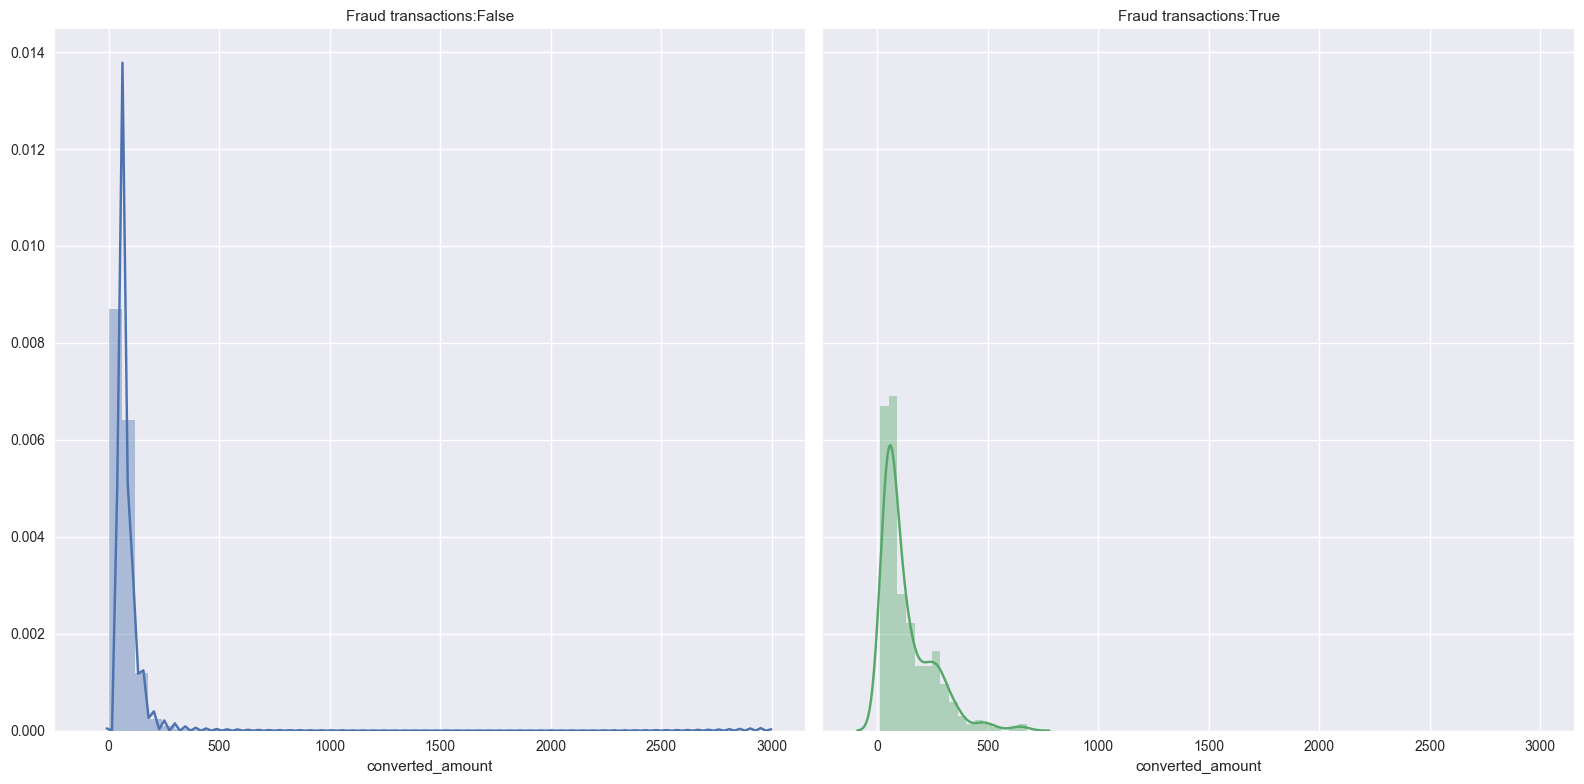

In [71]:
import seaborn as sns
g = sns.FacetGrid(cleaned_df, col="label", size=8,hue='label')
g.map(sns.distplot,"converted_amount",kde=True)
g.set_titles('Fraud transactions:{col_name}')

* Visualizing the categotical variables: currencycode and shopper interaction

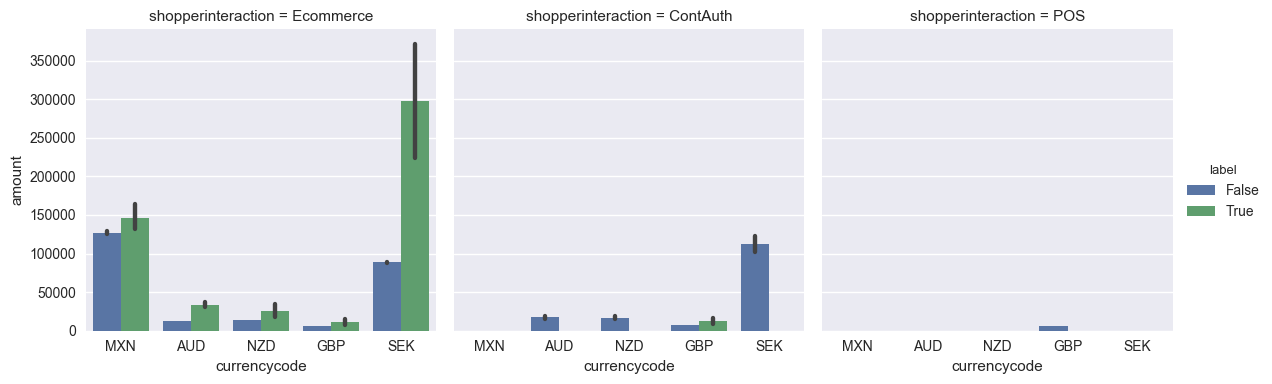

In [82]:
sns.factorplot(data=cleaned_df,x="currencycode", y="amount", hue="label",kind='bar',col='shopperinteraction')

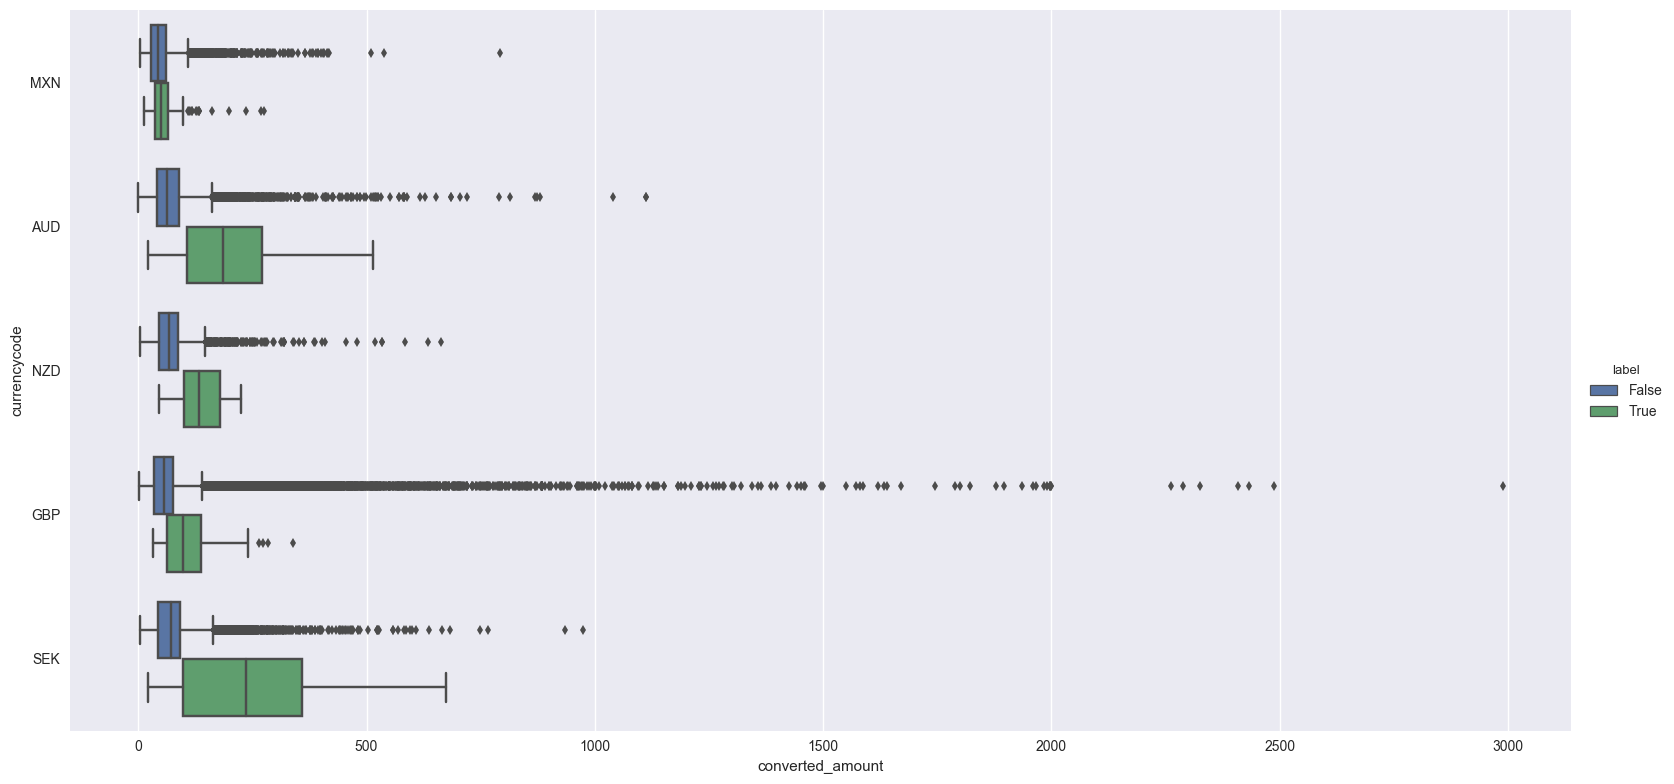

In [75]:
sns.factorplot(data=cleaned_df,x="converted_amount", y="currencycode", hue="label",kind='box',size=8, aspect=2)

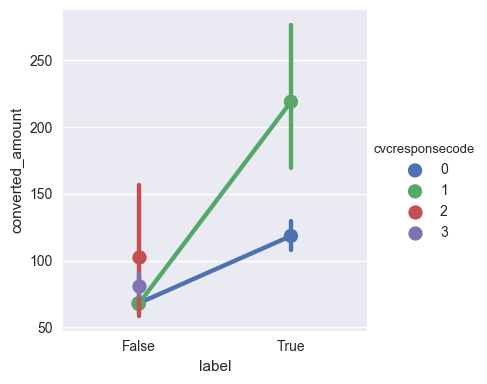

In [440]:
sns.factorplot(data=cleaned_df,x="label", y="converted_amount",hue="cvcresponsecode")

* Visualizing creation time

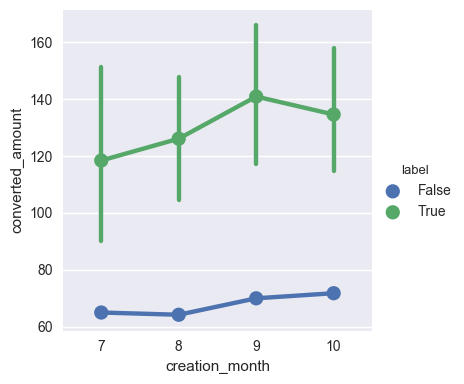

In [442]:
sns.factorplot(data=cleaned_df,x="creation_month", y="converted_amount",hue="label")

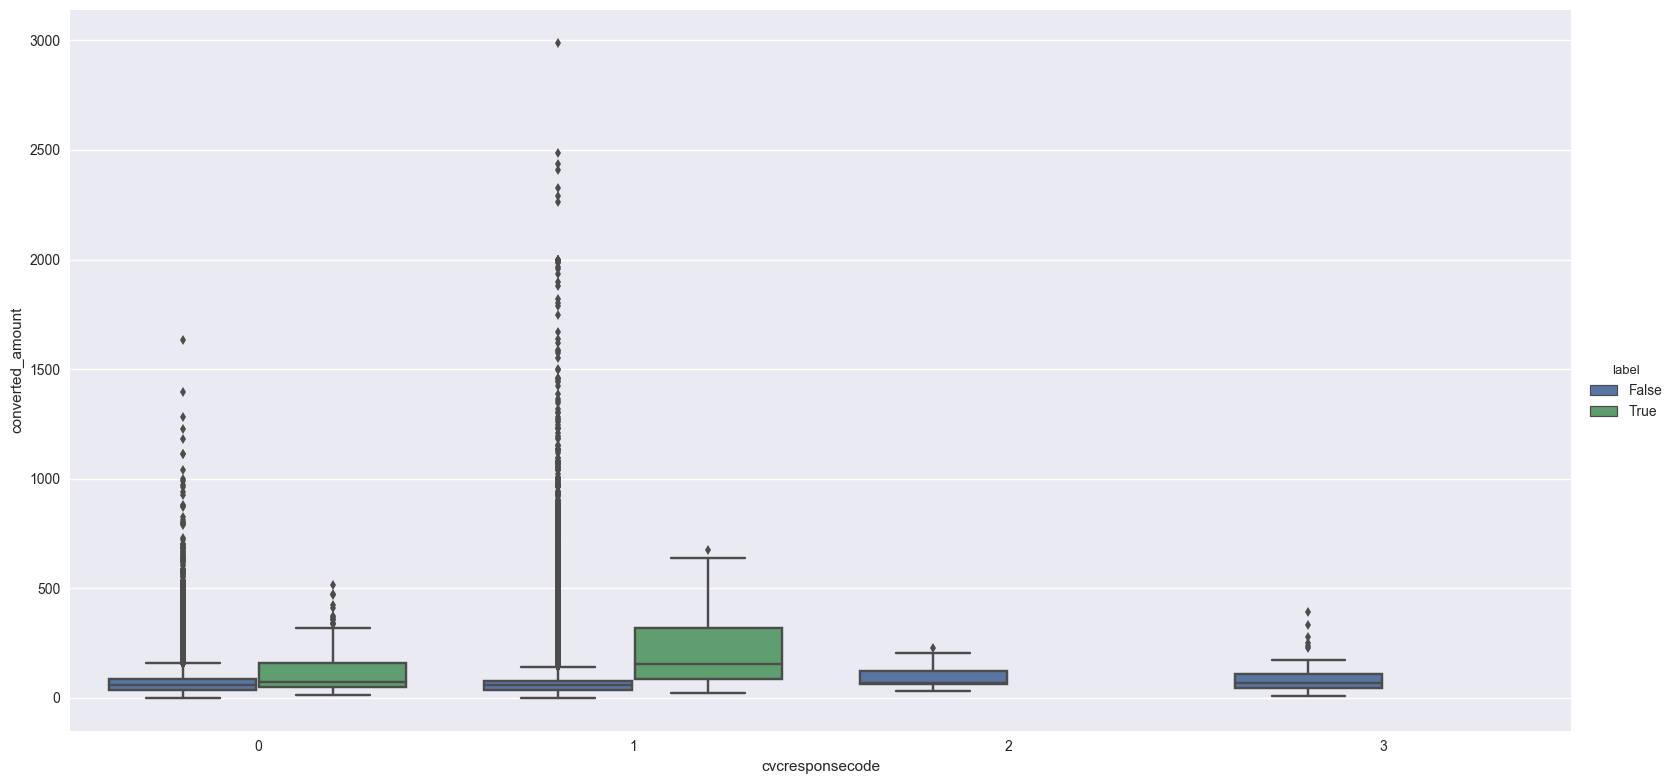

In [129]:
sns.factorplot(data=cleaned_df,x="cvcresponsecode", y="converted_amount", kind='box',hue="label",size=8, aspect=2)

In [133]:
# todo: visualize more time-series information

### Step2: Imblance  task

In [40]:
fraud_df = cleaned_df[cleaned_df['label']==True]
safe_df =  cleaned_df[cleaned_df['label']==False]

In [48]:
print 'Number of fraud:',len(fraud_df)
print 'Number of safe trasactions:',len(safe_df)
print 'Percentage of fraud:',100.0*len(fraud_df)/len(cleaned_df),'%'

Number of fraud: 345
Number of safe trasactions: 236691
Percentage of fraud: 0.14554751177 %


### Step3: Classification  task

Preprocessing data: prepare features

In [443]:
# For numerical variables, scale them
from sklearn.preprocessing import StandardScaler
cleaned_df['norm_amount'] = StandardScaler().fit_transform(cleaned_df['amount'].values.reshape(-1, 1))
cleaned_df['norm_converted_amount'] = StandardScaler().fit_transform(cleaned_df['converted_amount'].values.reshape(-1, 1))

In [185]:
# drop features that will not be used
data = cleaned_df.drop(['txid','bookingdate','amount','simple_journal','converted_amount','creation_date','date','creationdate','bin','mail_id','ip_id','card_id'],axis=1)
data.head()

,issuercountrycode,txvariantcode,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,label,creation_month,creation_weekday,creation_day,norm_amount,norm_converted_amount
0,MX,mccredit,MXN,MX,Ecommerce,True,0,MexicoAccount,True,7,2,2015-07-01,1.097667,-0.693177
1,MX,mccredit,MXN,MX,Ecommerce,True,0,MexicoAccount,True,7,3,2015-07-02,0.620582,-0.825965
2,MX,mccredit,MXN,MX,Ecommerce,True,0,MexicoAccount,True,7,3,2015-07-02,3.137865,-0.112231
3,MX,mccredit,MXN,MX,Ecommerce,True,0,MexicoAccount,True,7,4,2015-07-03,2.178900,-0.377806
4,MX,visaclassic,MXN,MX,Ecommerce,True,0,MexicoAccount,True,7,2,2015-07-08,1.699418,-0.527192


In [444]:
# Encode for ordinal feature: creation day
date_mapping = {label:idx for idx,label in enumerate(data['creation_day'].unique())}
data['creation_day'] = data['creation_day'].map(date_mapping)

In [212]:
# Encode for categorical variables
columns = list(data.columns)
columns.remove('norm_amount')
columns.remove('norm_converted_amount')
columns.remove('label')
columns.remove('creation_day')
columns.remove('creation_month')
#columns = ['issuercountrycode','txvariantcode','currencycode','shoppercountrycode','shopperinteraction']
encoded_data = pd.get_dummies(data,columns=columns,dummy_na=True)

In [147]:
# For installation, using: pip install -U imbalanced-learn
# Check this page: http://contrib.scikit-learn.org/imbalanced-learn/index.html
from imblearn.under_sampling import RandomUnderSampler

In [251]:
X = encoded_data.ix[:,encoded_data.columns !='label']
y = encoded_data.ix[:,encoded_data.columns =='label'].label
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X, y)

In [254]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size = 0.3, random_state = 0)

print "Number transactions train dataset: ", len(X_train)
print "Number transactions test dataset: ", len(X_test)
print "Total number of transactions: ", len(X_train)+len(X_test)

Number transactions train dataset:  483
Number transactions test dataset:  207
Total number of transactions:  690


In [452]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = X.columns

In [453]:
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [455]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    if importances[indices[f]]>0:
        print feat_labels[indices[f]], importances[indices[f]]

norm_amount 0.219204124896
norm_converted_amount 0.120123721614
issuercountrycode_BA 0.109944483189
issuercountrycode_AZ 0.107097802613
creation_day 0.0984353855705
issuercountrycode_AT 0.0498659166372
issuercountrycode_BD 0.0498359420481
issuercountrycode_AO 0.0478972667919
issuercountrycode_AE 0.0465128121638
creation_month 0.0366235578719
issuercountrycode_AM 0.0286422591702
issuercountrycode_AL 0.0171985679502
issuercountrycode_BE 0.015727008826
issuercountrycode_AR 0.0116322230813
issuercountrycode_BG 0.0114878367076
issuercountrycode_AI 0.0113650523621
issuercountrycode_BB 0.010899447698
issuercountrycode_AU 0.00750659080922


In [285]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
#y_pred = forest.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_pred=y_pred,y_true=y_test).ravel()
print 'precision:', float(tp)/(tp+fp)
print 'recall',float(tp)/(tp+fn)

precision: 0.895238095238
recall 0.903846153846


In [308]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.9, penalty='l1')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_pred=y_pred,y_true=y_test).ravel()
print 'precision:', float(tp)/(tp+fp)
print 'recall',float(tp)/(tp+fn)

precision: 0.858407079646
recall 0.932692307692


#### Feature selection
Select features that are above the

In [345]:
X_resampled_selected = forest.transform(X_resampled, threshold=0.01)
X_train, X_test, y_train, y_test = train_test_split(X_resampled_selected,y_resampled,test_size = 0.3, random_state = 0)

E:\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [419]:
selected_labels = X.columns[importances>=0.01]

In [377]:
lr = LogisticRegression(C=5, penalty='l1')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_pred=y_pred,y_true=y_test).ravel()
print 'precision:', float(tp)/(tp+fp)
print 'recall',float(tp)/(tp+fn)

precision: 0.857142857143
recall 0.923076923077


### 10 folds cross validation

In [399]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score
kfold = StratifiedKFold(y=y_train,
                       n_folds=10,
                       random_state=0)

In [400]:
scores = []
params = [0.1,0.3,1,3,10]
#params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
best_score = 0
best_c = 0
best_lr = LogisticRegression()
for c in params:
    lr = LogisticRegression(C=c, penalty='l1')
    for k, (train, test) in enumerate(kfold):
        lr.fit(X_train[train], y_train[train])
        y_scores = lr.predict_proba(X_train[test])[:,1]
        score = roc_auc_score(y_train[test], y_scores)
        scores.append(score)
    avg_score = np.mean(scores)
    print 'c =',c,'average auc score: ',avg_score
    if best_score < avg_score:
        best_score = avg_score
        best_lr = lr
        best_c = c
print 'best c=',best_c,', average auc score: ',best_score

c = 0.1 average auc score:  0.924342638889
c = 0.3 average auc score:  0.925206319444
c = 1 average auc score:  0.924664768519
c = 3 average auc score:  0.9238221875
c = 10 average auc score:  0.922776083333
best c= 0.3 , average auc score:  0.925206319444


### Plot ROC Curve
todo: plot ROC curve for different models

### explanation for logistic regression

In [401]:
best_lr.coef_

array([[  1.03215536e-01,   8.27071545e-04,   5.19489968e-01,
          1.12944783e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -7.47459990e-01,   0.00000000e+00,
          0.00000000e+00,  -1.37350947e-01,   0.00000000e+00,
          0.00000000e+00,  -2.72647496e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

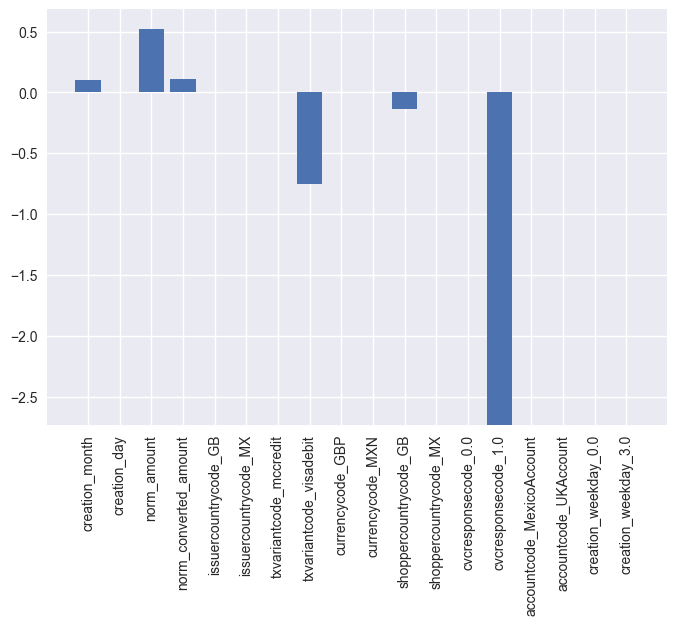

In [438]:
plt.bar(range(X_resampled_selected.shape[1]),best_lr.coef_.T)
plt.xticks(range(X_resampled_selected.shape[1]),selected_labels,rotation=90)
plt.show()

- issuercountrycode: country where the card was issued
- txvariantcode: the card type that was used (subbrand of visa or master card)
- bin: card issuer identifier
- amount/currencycode: transaction amount in minor units (so 100 EUR = 100 euro cent)
- shoppercountrycode: IP address country
- shopperinteraction: Ecommerce if it was an online transaction, ContAuth if it was a (monthly) subscription
- simple_journal: Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud”
- bookingdate: only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.
- cardverificationresponsesupplied: did the shopper provide his 3 digit CVC/CVV2 code?
- cvcresponsecode: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
- creationdate: Date of transaction
- accountcode: merchant’s webshop
- mail_id: Email address
- ip_id: Ip address
- card_id: Card number